## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import open3d as o3d
import k3d
import io
import cv2
import json

## Data preprocessing
Block of code about transforming the data from .mkv Azure Kinect files to depth and rgb pictures and video.

Extract data from .mkv file without Azure Kinect SDK

In [2]:
# Extract depth images
# !ffmpeg -i ../data/capture.mkv -map 0:1 -vsync 0 ../data/depth%04d.png

In [3]:
# Extract rgb images
# !ffmpeg -i ../data/capture.mkv -map 0:0 -vsync 0 ../data/color%04d.png

In [4]:
# Extract IR (?) images
# !ffmpeg -i ../data/capture.mkv -map 0:2 -vsync 0 ../data/ir%04d.png

Load images and camera metadata parameters

In [2]:
with open('data/mkv_meta.json') as f:
    intrinsic_params = json.load(f)

In [3]:
camera_intrinsic_params = {}
tmp = intrinsic_params['depth_intrinsics'].copy()
tmp.update(intrinsic_params['depth_resolution'].copy())
camera_intrinsic_params['height'] = tmp['h']
camera_intrinsic_params['width'] = tmp['w']
camera_intrinsic_params['fx'] = tmp['fx']
camera_intrinsic_params['fy'] = tmp['fy']
camera_intrinsic_params['cx'] = tmp['cx']
camera_intrinsic_params['cy'] = tmp['cy']

In [4]:
# intrinsic_params

In [5]:
depth_img = cv2.imread('data/depth0177.png', -1)
color_img = cv2.imread('data/color0177.png', -1)
print(depth_img.shape, color_img.shape)

(576, 640) (1536, 2048, 3)


## Experiments with rgb and depth images

In [9]:
color_img_new = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
color_img_new = cv2.resize(color_img_new, depth_img.T.shape)
color_img_new = cv2.transpose(color_img_new)

In [10]:
color_img_new.shape, depth_img.shape

((640, 576), (576, 640))

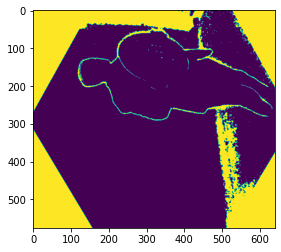

In [6]:
depth_new = depth_img.copy()
zero_mask = (depth_new == 0).astype(int)
inv_mask = 1 - zero_mask
plt.imshow(zero_mask)

## Open3D
Transform images to point clouds

In [7]:
camera_intrinsic_params

{'height': 576,
 'width': 640,
 'fx': 505.05084228515625,
 'fy': 504.9956359863281,
 'cx': 338.0733642578125,
 'cy': 338.06817626953125}

In [11]:
o3d_depth = o3d.geometry.Image(depth_img)
o3d_rgb = o3d.geometry.Image(color_img_new)
# camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
#     o3d.camera.PinholeCameraIntrinsicParameters.Kinect2ColorCameraDefault)
# camera_intrinsic = o3d.io.read_pinhole_camera_intrinsic('data/mkv_meta.json')
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(**camera_intrinsic_params)

In [12]:
# rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_rgb, o3d_depth)
dpth = o3d.geometry.PointCloud.create_from_depth_image(o3d_depth, camera_intrinsic, stride=1)

In [13]:
# pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, camera_intrinsic)
dpth.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
np.unique(np.asarray(o3d_depth), return_counts=True)

(array([   0,  653,  701, ..., 4355, 4361, 5855], dtype=uint16),
 array([95715,     1,     1, ...,     1,     1,     1]))

In [14]:
k3d.points(np.asarray(dpth.points), point_size=0.005)

/Users/aleksandr/miniconda/envs/kin/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [62]:
pcd = o3d.io.read_point_cloud('data/depth0177.ply', print_progress=True)

In [13]:
np.asarray(dpth.points).shape[0]

272925

In [86]:
arr = dpth.compute_nearest_neighbor_distance()
radii = np.asarray(arr).mean()
radii *= 3
radii

NameError: name 'dpth' is not defined

In [15]:
hull = dpth.compute_convex_hull()[0]

In [89]:
# dpth.estimate_normals()
# tetra, lst = o3d.geometry.TetraMesh.create_from_point_cloud(dpth)

# alpha_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(dpth, 10000)
k3d.mesh(np.asarray(alpha_mesh.vertices), np.asarray(alpha_mesh.tetras))
# k3d.points(np.asarray(dpth.points), point_size=0.005)

RuntimeError: [1;31m[Open3D ERROR] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh[0;m

In [88]:
len(lst)

272925

On the 2-nd coordinate we can clearly differentiate a person from the wall coordinates. Let's filter the wall out.

In [21]:
thresh = -1.8
mask = np.asarray(pcd.points)[:, 2] > thresh
new_pcd_array = np.asarray(pcd.points)[mask, :]

new_pcd = pcd.select_by_index(np.argwhere(mask==True).squeeze())
k3d.points(new_pcd.points, point_size = 0.005)

Output()

In [22]:
# Estimate normals
pcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))

In [23]:
dpth.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))

In [24]:
# trm_poisson, _ = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(dpth, 
#                                                                            depth=9,
#                                                                            width=0,
#                                                                            linear_fit=True, 
#                                                                            n_threads=-1)
trm_ball = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(dpth,
                o3d.utility.DoubleVector(np.array([radii, radii*2])))

In [25]:
# kmesh = k3d.mesh(np.asarray(trm_poisson.vertices), np.asarray(trm_poisson.triangles))
kmesh = k3d.mesh(np.asarray(trm_ball.vertices), np.asarray(trm_ball.triangles))
kpoints = k3d.points(dpth.points, point_size=0.0015, color=0xff0000)
plot = k3d.plot(name='trimesh and point cloud')
plot += kmesh
plot += kpoints
kmesh.shader = '3d'
kpoints.shader = '3d'
plot.display()
# tetra_mesh, _ = o3d.geometry.TetraMesh.create_from_point_cloud(pcd) 
# trm_

/Users/aleksandr/miniconda/envs/kin/lib/python3.8/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "int32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()

In [24]:
np.asarray(o3d_depth).astype(float)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
np.asarray(trm_ball.triangles)

array([[     1,    145,    146],
       [     1,     70,    145],
       [     4,    150,     73],
       ...,
       [272031, 272388, 272743],
       [272806, 272810, 272807],
       [272876, 272520, 272878]], dtype=int32)

In [39]:
np.asarray(trm_ball.vertices)[[1, 145, 146]]

array([[ 0.27250845,  1.88315641, -2.81299996],
       [ 0.25598112,  1.87334675, -2.81500006],
       [ 0.27367096,  1.88000162, -2.82500005]])

In [8]:
np.unique(depth_img, return_counts=True)

(array([   0,  653,  701, ..., 4355, 4361, 5855], dtype=uint16),
 array([95715,     1,     1, ...,     1,     1,     1]))

In [7]:
np.unique(np.asarray(depth_img))

array([   0,  653,  701, ..., 4355, 4361, 5855], dtype=uint16)

## Own meshing function

In [200]:

def fast_shift(arr, num, fill_value, axis):
    '''
        arr: array to shift
        num: shift number
        fill_value: value to fill shifted values
        axis: axis to shift along
    '''
    #if axis not in (0, 1):
     #   raise ValueError(f'Wring axis {axis}')
    result = np.empty_like(arr)
    if num > 0:
        if axis == 0:
            result[num:] = arr[:-num]
            result[:num] = fill_value
        else:
            result[:, num:] = arr[:, :-num]
            result[:, :num] = fill_value

    elif num < 0:
        if axis == 0:
            result[:num] = arr[-num:]
            result[num:] = fill_value
        else:
            result[:, :num] = arr[:, -num:]
            result[:, num:] = fill_value
    else:
        result[:] = arr
    return result

def fast_make_points(depth, intr, extr=None):
    # Depth map and intrinsic params
    h, w = depth.shape
    fx, fy = intr['fx'], intr['fy']
    cx, cy = intr['cx'], intr['cx']
    # Calculate xyz
    non_zero = depth > 0
    i, j = np.nonzero(non_zero)
    z = depth[non_zero]
    count_non_zero = i.shape[0]
    u = (i - cx) * z / fx
    v = (j - cy) * z / fy
    pts = np.array([u, v, -z], dtype=np.float32).T
    # Index the non-zero pixels
    indices = np.arange(1, count_non_zero+1, 1, dtype=np.int_)
    ids1 = np.zeros_like(depth, dtype=np.int32)
    ids1[non_zero] = indices
    
    ids2 = fast_shift(ids1, num=1, fill_value=0, axis=0)
    
    ids3 = fast_shift(ids1, num=1, fill_value=0, axis=1)
    
    ids_tmp = fast_shift(ids1, num=1, fill_value=0, axis=0)
    ids4 = fast_shift(ids_tmp, num=1, fill_value=0, axis=1)
    
    
    # Construct triangles
    mask1 = (ids1 < count_non_zero) * (ids1 > 0) 
    mask2 = (ids2 < count_non_zero) * (ids2 > 0)
    mask3 = (ids3 < count_non_zero) * (ids3 > 0)
    mask4 = (ids4 < count_non_zero) * (ids4 > 0)
    upper_tri_mask = mask1 * mask2 * mask3
    lower_tri_mask = mask2 * mask3 * mask4
    upper_num = np.sum(upper_tri_mask)
    lower_num = np.sum(lower_tri_mask)
    # Collect into a single array
    tri = np.empty((3, upper_num + lower_num), dtype=np.uint32)
    
    print(upper_num, lower_num)
    tri[0, :upper_num]= ids1[upper_tri_mask]
    tri[1, :upper_num]= ids2[upper_tri_mask]
    tri[2, :upper_num]= ids3[upper_tri_mask]
    
    tri[0, upper_num:]= ids3[lower_tri_mask]
    tri[1, upper_num:]= ids2[lower_tri_mask]
    tri[2, upper_num:]= ids4[lower_tri_mask]
    
    tri = tri.T
#     tri[:upper_num] = np.vstack([ids1[upper_tri_mask], 
#                                  ids2[upper_tri_mask], 
#                                  ids3[upper_tri_mask]]).T
#     tri[upper_num:] = np.vstack([ids3[lower_tri_mask], 
#                                  ids2[lower_tri_mask], 
#                                  ids4[lower_tri_mask]]).T
    return ids1, tri, pts


In [201]:
%load_ext line_profiler

%time ids, tri, pts = fast_make_points(depth_img, camera_intrinsic_params)
%lprun -f fast_make_points ids, tri, pts = fast_make_points(depth_img, camera_intrinsic_params)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
267682 267519
CPU times: user 15.4 ms, sys: 5.63 ms, total: 21.1 ms
Wall time: 19.8 ms
267682 267519


Timer unit: 1e-06 s

Total time: 0.017641 s
File: <ipython-input-200-843147d506bf>
Function: fast_make_points at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                           def fast_make_points(depth, intr, extr=None):
    31                                               # Depth map and intrinsic params
    32         1          3.0      3.0      0.0      h, w = depth.shape
    33         1          1.0      1.0      0.0      fx, fy = intr['fx'], intr['fy']
    34         1          1.0      1.0      0.0      cx, cy = intr['cx'], intr['cx']
    35                                               # Calculate xyz
    36         1        344.0    344.0      2.0      non_zero = depth > 0
    37         1       2401.0   2401.0     13.6      i, j = np.nonzero(non_zero)
    38         1        432.0    432.0      2.4      z = depth[non_zero]
    39         1          3.0      3.0      0.0      count_non_zero = i.shape[0]
    40        

In [57]:
print('tri:\n', np.unique(tri, return_counts=True))
print('ids:\n', np.unique(ids, return_counts=True))
print('pts:\n', pts.shape)
print('depth_img:\n', np.unique(depth_img, return_counts=True))
tri.shape, ids.shape, np.sum((ids>0).astype(bool))

tri:
 (array([     1,      3,      4, ..., 272922, 272923, 272924], dtype=uint32), array([1, 1, 3, ..., 3, 3, 2]))
ids:
 (array([     0,      1,      2, ..., 272923, 272924, 272925], dtype=int32), array([95715,     1,     1, ...,     1,     1,     1]))
pts:
 (272925, 3)
depth_img:
 (array([   0,  653,  701, ..., 4355, 4361, 5855], dtype=uint16), array([95715,     1,     1, ...,     1,     1,     1]))


((535201, 3), (576, 640), 272925)

In [58]:
o3d_mesh = o3d.geometry.TriangleMesh(o3d.utility.Vector3dVector(pts), o3d.utility.Vector3iVector(tri))

In [82]:
tri

array([[    71,     73,     74, ..., 272923, 272924, 272925],
       [     1,      4,      5, ..., 272568, 272569, 272570],
       [    70,     72,     73, ..., 272922, 272923, 272924]],
      dtype=uint32)

In [13]:
pcd = o3d.io.read_point_cloud('data/depth0177.ply', print_progress=True)
pcd

PointCloud with 238765 points.

In [60]:
o3d.io.write_triangle_mesh('my_mesh_fast.ply', o3d_mesh)

True

In [64]:
o3d.io.write_triangle_mesh('data/poisson_mesh.ply', trm_poisson, print_progress=True)
o3d.io.write_triangle_mesh('data/ball_mesh.ply', trm_ball, print_progress=True)

NameError: name 'trm_poisson' is not defined

In [44]:
o3d.utility.DoubleVector(np.array([1., 1.]))

DoubleVector[1, 1]

In [ ]:
np.asarray(trm.triangles)

In [ ]:
trm.compute_vertex_normals()

In [ ]:
trm.compute_triangle_normals()

In [ ]:
o3d.visualization.draw_geometries([trm])

In [ ]:
mesh_box = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                height=1.0,
                                                depth=1.0)

In [ ]:
print(np.asarray(pcd.points).shape)

In [17]:
o3d.io.write_point_cloud('data/depth0177.ply', pcd, print_progress=True)

True

In [ ]:
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

In [ ]:
o3d.visualization.draw_geometries([pcd])

In [ ]:
pcd = o3d.io.read_point_cloud('data/depth0177.ply')